In [ ]:
import os
import cv2
import torch
import matplotlib.pyplot as plt

from utils import *
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Validation Data

In [2]:
val_df= pd.read_csv('checkpoints/val_split.csv')
val_df = val_df.loc[:, ~val_df.columns.str.contains('^Unnamed')]

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_dataset=FacialAttributeDataset(val_df, transform=val_transform,root_dir='./')

## Load Model

In [3]:
model = MultiTaskFacialAttributeClassifier(pretrained=True)
checkpoint = torch.load('checkpoints/best_model.pth', map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

model = model.to(device)
model.eval();


/home/rami/therapancea/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rami/therapancea/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Run inference on the validation set

In [4]:
def get_logits_for_dataframe(dataset,model, device, batch_size=32, transform=None):
    """
    Get logits for all images in the dataframe
    """
    model.eval()
    
    # Create dataset and dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    all_logits = {'glasses': [], 'hat': [], 'facial_hair': [], 'label': []}
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting predictions"):
            if len(batch) == 2:
                batch, _ = batch  # If batch returns a tuple (images, labels)
            batch = batch.to(device)
            outputs = model(batch)  # Returns dict with keys: glasses, hat, facial_hair, label
            
            # Collect logits for each task
            for task in all_logits.keys():
                all_logits[task].extend(outputs[task].cpu().numpy())
    
    return all_logits

# Get logits for all images
print("Getting model predictions...")
val_logits = get_logits_for_dataframe(val_dataset, model, device='cuda', transform=val_transform)

# Add sigmoid probability columns to dataframe
val_df['glasses_logit'] = torch.sigmoid(torch.tensor(val_logits['glasses'])).numpy()
val_df['hat_logit'] = torch.sigmoid(torch.tensor(val_logits['hat'])).numpy()
val_df['facial_hair_logit'] = torch.sigmoid(torch.tensor(val_logits['facial_hair'])).numpy()
val_df['label_logit'] = torch.sigmoid(torch.tensor(val_logits['label'])).numpy()

# Verify the new shape
print(f"Original columns: {len(val_df.columns) - 4}")
print(f"New columns: {len(val_df.columns)}")
print(f"DataFrame shape: {val_df.shape}")

Getting model predictions...


Getting predictions: 100%|██████████| 625/625 [00:25<00:00, 24.07it/s]
/tmp/ipykernel_51768/2930404498.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  val_df['glasses_logit'] = torch.sigmoid(torch.tensor(val_logits['glasses'])).numpy()


Original columns: 5
New columns: 9
DataFrame shape: (20000, 9)


## Analyse Hter per class

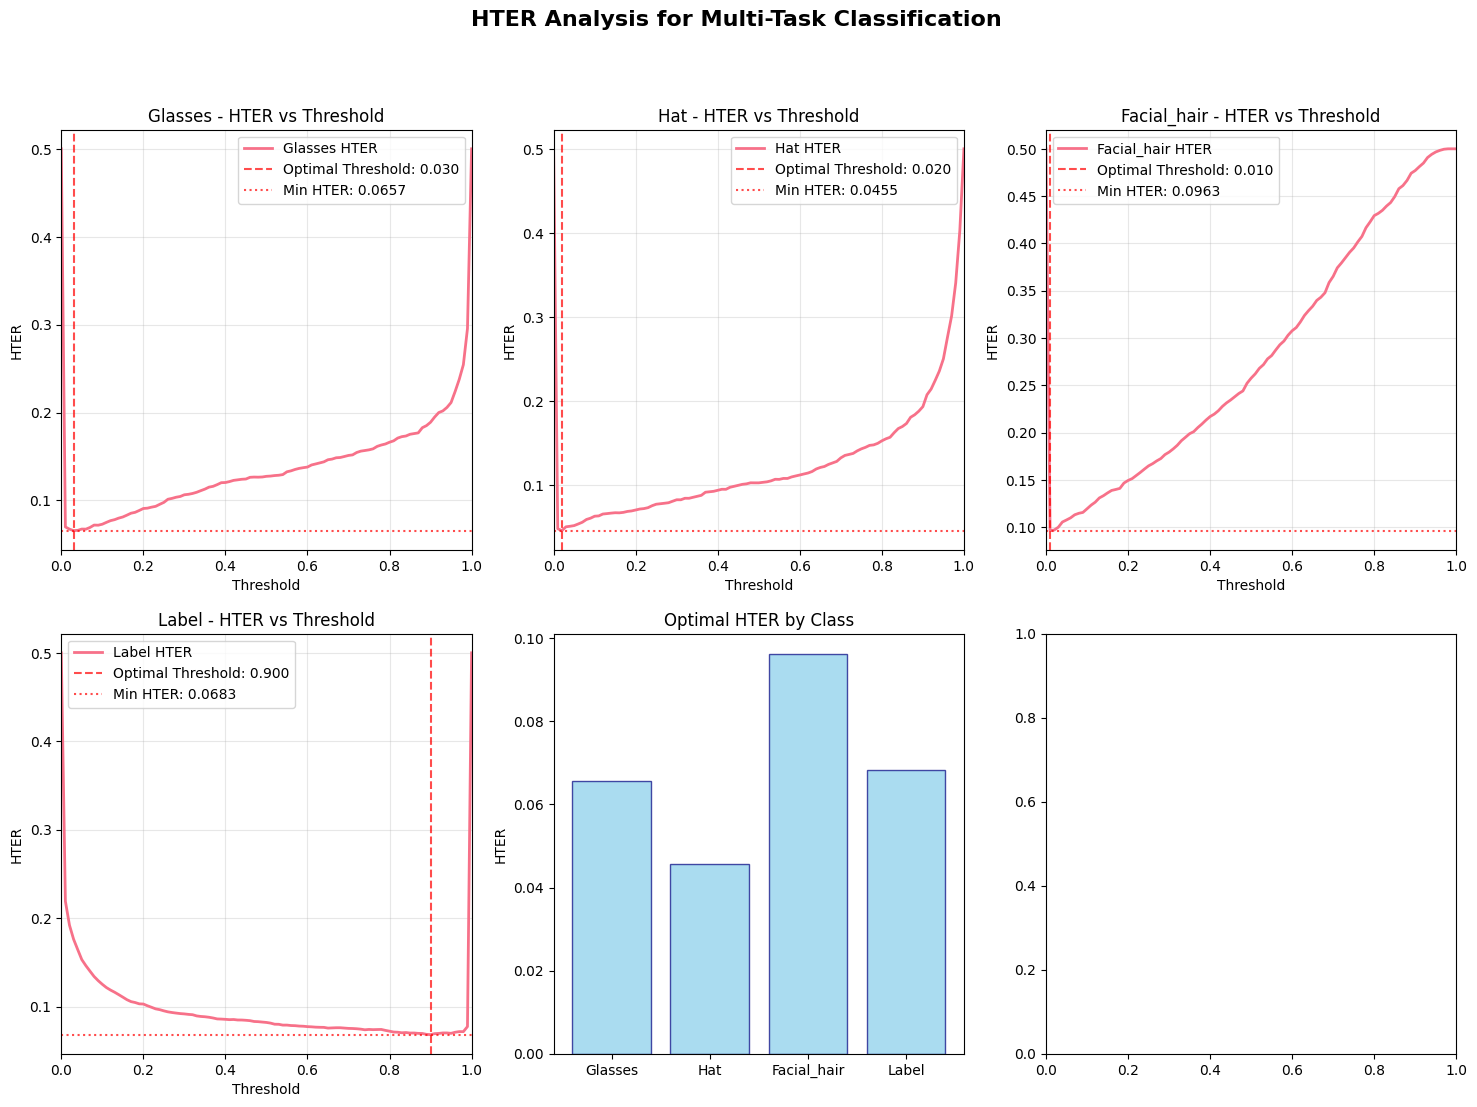

In [5]:
visualize_hter_analysis(val_df)

In [12]:
# create ecombined_label column 1 if hat_logit > 0.5 or glasses_logit > 0.5 or facial_hair_logit > 0.5 else 0
val_df['combined_label'] = ((val_df['hat_logit'] > 0.02) |
                           (val_df['glasses_logit'] > 0.06) |
                           (val_df['facial_hair_logit'] > 0.01)).astype(int)


### Compare label predictoin vs Combined from Attributes

In [13]:
# compare the f1 for label_logit and combined_label
from sklearn.metrics import f1_score
f1_label = f1_score(val_df['label'], (val_df['label_logit'] > 0.8).astype(int))
f1_combined = f1_score(val_df['label'],(val_df['combined_label'] < 0.5).astype(int))
print(f"F1 Score for label_logit: {f1_label:.4f}")
print(f"F1 Score for combined_label: {f1_combined:.4f}")

F1 Score for label_logit: 0.9609
F1 Score for combined_label: 0.9570


## Run inference on Test Data

In [14]:
test_df=pd.DataFrame({
    'image_path':[f'val_img/{file_name}' for file_name in os.listdir('./val_img')],
})
test_dataset=inferenceDataset(test_df,'./',transform=val_transform)

In [15]:
# Get logits for all images
test_logits = get_logits_for_dataframe(test_dataset, model, device='cuda', transform=val_transform)

# Add sigmoid probability columns to dataframe
test_df['glasses_logit'] = torch.sigmoid(torch.tensor(test_logits['glasses'])).numpy()
test_df['hat_logit'] = torch.sigmoid(torch.tensor(test_logits['hat'])).numpy()
test_df['facial_hair_logit'] = torch.sigmoid(torch.tensor(test_logits['facial_hair'])).numpy()
test_df['label_logit'] = torch.sigmoid(torch.tensor(test_logits['label'])).numpy()

Getting predictions: 100%|██████████| 625/625 [00:25<00:00, 24.35it/s]


In [16]:
test_df

,image_path,glasses_logit,hat_logit,facial_hair_logit,label_logit
0,val_img/010252.jpg,0.000121,0.000087,0.000092,0.998183
1,val_img/017045.jpg,0.000016,0.000013,0.000012,0.999698
2,val_img/012234.jpg,0.020879,0.998898,0.593763,0.000021
3,val_img/004491.jpg,0.000022,0.000020,0.000020,0.999442
4,val_img/015620.jpg,0.000008,0.000006,0.000004,0.999785
...,...,...,...,...,...
19995,val_img/018605.jpg,0.000010,0.000014,0.000008,0.999736
19996,val_img/013343.jpg,0.000003,0.000003,0.000004,0.999821
19997,val_img/008009.jpg,0.022998,0.011250,0.681044,0.063618
19998,val_img/008018.jpg,0.000017,0.000014,0.000009,0.999697


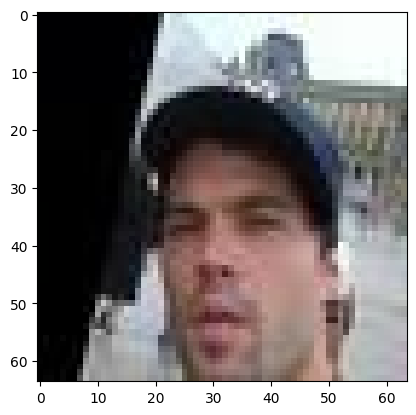

In [83]:
example= test_df[test_df['label_logit']<0.9].sample(1).iloc[0]
example
plt.imshow(cv2.imread(example['image_path'])[:,:,::-1])
plt.show()

In [62]:
test_df['label']= (test_df['label_logit'] > 0.9).astype(int)

In [63]:
test_df

,image_path,glasses_logit,hat_logit,facial_hair_logit,label_logit,label
0,val_img/010252.jpg,0.000121,0.000087,0.000092,0.998183,1
1,val_img/017045.jpg,0.000016,0.000013,0.000012,0.999698,1
2,val_img/012234.jpg,0.020879,0.998898,0.593763,0.000021,0
3,val_img/004491.jpg,0.000022,0.000020,0.000020,0.999442,1
4,val_img/015620.jpg,0.000008,0.000006,0.000004,0.999785,1
...,...,...,...,...,...,...
19995,val_img/018605.jpg,0.000010,0.000014,0.000008,0.999736,1
19996,val_img/013343.jpg,0.000003,0.000003,0.000004,0.999821,1
19997,val_img/008009.jpg,0.022998,0.011250,0.681044,0.063618,0
19998,val_img/008018.jpg,0.000017,0.000014,0.000009,0.999697,1


In [84]:
test_df.to_csv('checkpoints/test_df.csv', index=False)
# save the labels in txt file 
with open('checkpoints/test_labels.txt', 'w') as f:
    for index, row in test_df.iterrows():
        f.write(f"{row['label']}\n")